# Alireza Farajtabrizi (97102185)

### Importing Libraries and Functions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import skimage.io as io

from sklearn.svm import SVC
from skimage.transform import rescale
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support


# Part 1 (Optical Flow Webcam)

### Dense

در این قسمت و قسمت بعد جهت بسته شدن پنجره ی وبکم دکمه ی q را فشار دهید

In [1]:
webcam = cv2.VideoCapture(0)
frame_old = cv2.cvtColor(webcam.read()[1], cv2.COLOR_BGR2GRAY)

hsv = np.zeros_like(webcam.read()[1])
start_time = time.time()

while(time.time() < start_time + 30):
    
    frame_new = cv2.cvtColor(webcam.read()[1], cv2.COLOR_BGR2GRAY)
    optical_flow = cv2.calcOpticalFlowFarneback(frame_old, frame_new, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, angle = cv2.cartToPolar(optical_flow[..., 0], optical_flow[..., 1])
    frame_old = frame_new

    hsv[:,:,0] = angle/np.pi*90
    hsv[:,:,1] = 255
    hsv[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
    cv2.imshow('', cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))
    
    if (cv2.waitKey(100) & 0xFF == ord('q')):
        break

webcam.release()
cv2.destroyAllWindows()

### Sparse

In [2]:
webcam = cv2.VideoCapture(0)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = webcam.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

start_time = time.time()

while(time.time() < start_time + 30):
    ret, frame = webcam.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    cv2.imshow('frame', img)

    if (cv2.waitKey(100) & 0xFF == ord('q')):
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)



webcam.release()
cv2.destroyAllWindows()

## Part 2 (Classification using SVM and Optical Flow)

### Functions to do the Pre-Process

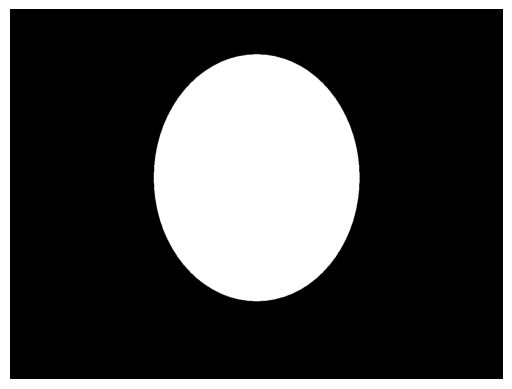

In [3]:
def flow(frame_old, frame_new):
    optical_flow = cv2.calcOpticalFlowFarneback(frame_old, frame_new, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return cv2.cartToPolar(optical_flow[..., 0], optical_flow[..., 1])
def get_hist_flow(images):
    n = len(images)
    hist = np.zeros((n-1, 8))
    for i in range(n-1):
        magnitude, angle = flow(images[i], images[i+1])
        hist[i,:] = np.histogram(angle, range=(0, 2*np.pi), bins=8)[0]
    return hist

center = 600, 410
axes = 250, 300
mask = np.zeros((900, 1200), np.uint8)
cv2.ellipse(mask, center, axes, 0, 0, 360, 1, -1)

plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.show()

### Loading and Processing Frames

In [4]:
hist_happy = np.zeros((30, 16))
folder_dir = 'Happy Videos'
i = 0 

for file in os.listdir(folder_dir):
    images = []
    for image in os.listdir(folder_dir+'/'+file):
        img= io.imread(folder_dir+'/'+file+'/'+image, as_gray=True)
        img = rescale(img*mask, 0.5, anti_aliasing = True)
        images.append(img)
    hists = get_hist_flow(images)
    hist_happy[i,:8] = np.mean(hists,axis = 0)
    hist_happy[i,8:] = np.max(hists, axis = 0)
    i += 1
    
images = []   
hist_surprise = np.zeros((30, 16))
folder_dir = 'Surprise Videos'
i = 0

for file in os.listdir(folder_dir):
    images = []  
    for image in os.listdir(folder_dir+'/'+file):
        img= io.imread(folder_dir+'/'+file+'/'+image, as_gray=True)
        img = rescale(img*mask, 0.5, anti_aliasing = True)
        images.append(img)
    hists = get_hist_flow(images)
    hist_surprise[i,0:8] = np.mean(hists, axis = 0)
    hist_surprise[i,8:16] = np.max(hists, axis = 0)
    i += 1

### Splitting Data and Grid Search

In [20]:
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((hist_happy, hist_surprise)),
                                                    np.concatenate((np.zeros(len(hist_happy)),
                                                                    np.ones(len(hist_surprise)))),
                                                    train_size=0.7,
                                                    random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(kernel = 'rbf')

C_range = np.logspace(-10, 10, 21)
gamma_range = np.logspace(-10, 10, 21)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'gamma': 0.1} with a score of 0.74


### Fitting Metrics

In [21]:
C, gamma = grid.best_params_['C'], grid.best_params_['gamma']
clf = SVC(kernel = 'rbf', C=C, gamma=gamma)
clf.fit(X_train, y_train)

y_train_p= clf.predict(X_train)
y_test_p = clf.predict(X_test)

print("Confusion Matrix for train : \n" , confusion_matrix(y_train, y_train_p))
print("Confusion Matrix for test : \n" , confusion_matrix(y_test, y_test_p))


persicion_train = precision_recall_fscore_support(y_train, y_train_p)[0]
recall_train = precision_recall_fscore_support(y_train, y_train_p)[1]
persicion_test = precision_recall_fscore_support(y_test, y_test_p)[0]
recall_test = precision_recall_fscore_support(y_test, y_test_p)[1]

print("Persicion of train for each class : \t", persicion_train , "\tand on average : \t" , np.mean(persicion_train))
print("Persicion of test for each class : \t", persicion_test ,"\tand on average : \t" , np.mean(persicion_test))
print("Recall of train for each class : \t", recall_train,"\tand on average : \t" , np.mean(recall_train))
print("Recall of test for each class : \t", recall_test,"\tand on average : \t" , np.mean(recall_test))

Confusion Matrix for train : 
 [[22  0]
 [ 0 20]]
Confusion Matrix for test : 
 [[6 2]
 [3 7]]
Persicion of train for each class : 	 [1. 1.] 	and on average : 	 1.0
Persicion of test for each class : 	 [0.66666667 0.77777778] 	and on average : 	 0.7222222222222222
Recall of train for each class : 	 [1. 1.] 	and on average : 	 1.0
Recall of test for each class : 	 [0.75 0.7 ] 	and on average : 	 0.725


دلیل اینکه درصد حدود 70 است احتمالا تعداد دیتای کم می باشد